In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd 
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from tqdm import tqdm

TYPE = 'NC'
data_dir = '/Users/govindramesh/Horizon/SPECT-{}w'.format(TYPE) #path to parent folder with scans
scans = [] #list to hold dicom files

for root, subdirs, files in os.walk(data_dir):
    for file in files:    
        if file != '.DS_Store': #skip hidden files
            scans.append(pydicom.read_file(root + "/" + file))

for x in range(len(scans[:0])): #goes through each patient in the list
    for i in range(scans[x].pixel_array.shape[0]): #goes through each scan (91 total)
        #print(x,i)
        plt.imshow(scans[x].pixel_array[i,:,:], cmap = 'gray')
        plt.show()

print(len(scans))

193


In [2]:
scanspa = [] #list to hold pixel arrays from dicom files
for x in range(len(scans)):
    scanspa.append(scans[x].pixel_array)
    #scanspa.append(np.flip(scans[x].pixel_array, axis = 2)) #flips scans horizontally for data augmentation
    
print(len(scanspa))

193


39


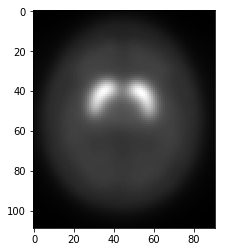

(91, 109, 91) int64


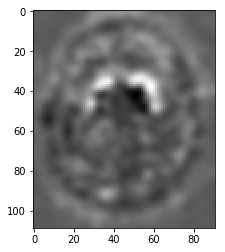

In [15]:
#average of all scans
scans_mean = np.mean(scanspa, axis=0)
for x in range(39,40):
    print(x)
    plt.imshow(scans_mean[x], cmap = 'gray')
    plt.show()

scans_mean = scans_mean.astype(int)
print(scans_mean.shape, scans_mean.dtype)
for i in range(len(scanspa)):
    scanspa[i]=scanspa[i]-scans_mean
    

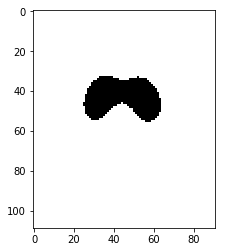

In [17]:
meanscanmask = [] #list to hold bool/mask representation of the mean scan

THRESHOLD = .35
for x in range(len(scans_mean)):
    meanscanmask.append(scans_mean[x]<THRESHOLD*32767) #condition determining bool value
    
plt.imshow(meanscanmask[39], cmap = 'gray')
plt.show()

In [54]:
#create rectangular box around area containing mask
mask_dim_x = []
mask_dim_y = []
mask_dim_z = []

for a in range(len(scans_mean)):
    mask_dim_x.append(np.where(meanscanmask[a]==False)[0]) #returns x indices where false
    mask_dim_y.append(np.where(meanscanmask[a]==False)[1]) #returns y indices where false
    #print(np.where(meanscanmask[a]==False))
    if(np.where(meanscanmask[a]==False)[0].size>0):mask_dim_z.append(a)

#print(max(mask_dim_z))


max_index = 0 #index of the slice with the highest amount of threshold-exceeding values

for c in range(len(meanscanmask)):
    if len(mask_dim_x[c]) > len(mask_dim_x[max_index]): max_index = c
    
    
#uses max and min indices of contour mask to create rectangular mask
meanscanmask[max_index][mask_dim_x[max_index].min() : mask_dim_x[max_index].max()+1,
                        mask_dim_y[max_index].min() : mask_dim_y[max_index].max()+1] = False


#mask to be used on all the scans
FINAL_MASK = meanscanmask[max_index]

print(mask_dim_x[max_index].min(), mask_dim_x[max_index].max())
print(mask_dim_y[max_index].min(), mask_dim_y[max_index].max())

print(max_index)
#print(FINAL_MASK[mask_dim_x[max_index].min() : mask_dim_x[max_index].max()+1,
#                 mask_dim_y[max_index].min() : mask_dim_y[max_index].max()+1])

33 55
25 63
39


In [50]:
maskedscans = [] #list to hold scans with masks applied
for a in range(len(scanspa)):
    temp = []
    for b in range(len(scanspa[a][min(mask_dim_z):max(mask_dim_z)])):
        #applying bool mask to original scans
        temp.append(np.ma.masked_where(FINAL_MASK, scanspa[a][b]))
    maskedscans.append(temp)

In [ ]:
#save each masked scan to folders
for a in tqdm(range(len(maskedscans[:1]))):
    #os.makedirs('/Users/govindramesh/Horizon/FINAL_IMAGES/{}/{}-{}'.format(TYPE,TYPE,a), exist_ok = True)
    for b in range(len(maskedscans[a])):
        #print(a,b)
        #plt.imsave('/Users/govindramesh/Horizon/FINAL_IMAGES/{}/{}-{}/{}-{}-{}.tiff'.format(TYPE,TYPE,a,TYPE,a,b), 
        #           maskedscans[a][b], cmap = "gray")
        #plt.imshow(maskedscans[a][b], cmap = 'gray')
        #plt.show()
        #plt.imshow(scanspa[a][b], cmap = 'gray')
        #plt.show()

In [51]:
for a in tqdm(range(len(maskedscans))):
    for b in range(len(maskedscans[a])):
        maskedscans[a][b] = maskedscans[a][b].compressed().reshape(23,39,1)

100%|██████████| 193/193 [00:00<00:00, 1016.32it/s]


In [52]:
for a in tqdm(range(len(maskedscans))):    
    maskedscans[a]= np.array(maskedscans[a])

100%|██████████| 193/193 [00:00<00:00, 3886.90it/s]


In [53]:
os.makedirs('/Users/govindramesh/Horizon/FINAL_IMAGES', exist_ok = True)
FINAL_IMAGES = []
for a in tqdm(range(len(maskedscans))):
    FINAL_IMAGES.append(maskedscans[a])
            
FINAL_IMAGES = np.array(FINAL_IMAGES)
FINAL_IMAGES.shape
#np.save('/Users/govindramesh/Horizon/FINAL_IMAGES/{}wa'.format(TYPE), FINAL_IMAGES)


100%|██████████| 193/193 [00:00<00:00, 30760.78it/s]


(193, 18, 23, 39, 1)